In [1]:
!rm ita-eng.zip &> /dev/null
!rm rm -rf dataset &> /dev/null
!wget "https://www.manythings.org/anki/ita-eng.zip" &> /dev/null
!unzip "ita-eng.zip" -d "dataset" &> /dev/null

text_file = "dataset/ita.txt"

In [2]:
! pip install transformers[sentencepiece] datasets &> /dev/null
! pip install sacrebleu sentencepiece &> /dev/null
! pip install huggingface_hub &> /dev/null
! pip install datasets transformers[sentencepiece] sacrebleu &> /dev/null
! pip install telepot &> /dev/null
! pip install evaluate &> /dev/null
! pip install telepot &> /dev/null

In [3]:
num_of_tests = 100

with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs2 = []
for line in lines:
    eng, ita, _ = line.split("\t")
    ita = "[start] " + ita + " [end]"
    text_pairs2.append((eng, ita))

import random
random.seed(39081)
random.shuffle(text_pairs2)

num_train_samples = int(len(text_pairs2) * 0.80)
train_pairs = text_pairs2[:num_train_samples]
test_pairs2 = text_pairs2[num_train_samples:]

def the_metric(target, output):
    import evaluate
    predictions = [output]
    references = [target]
    bleu = evaluate.load("bleu")
    results = bleu.compute(predictions=predictions, references=references)["bleu"]
    return results

def clean(word):
    clean_word = word.lower()
    clean_word = clean_word.replace(".", "")
    clean_word = clean_word.replace("\"", "")
    clean_word = clean_word.replace(",", "")
    clean_word = clean_word.replace("’", "'")
    clean_word = clean_word.replace("[start]", "")
    clean_word = clean_word.replace("[end]", "")
    clean_word = clean_word.strip()
    return clean_word

def evaluate_model(translate_function):
    result = 0
    count = 0
    for i, item in enumerate(test_pairs2[0:num_of_tests]):
        input_eng = clean(item[0])  # eng
        target = clean(item[1])  # ita
        output = clean(translate_function(input_eng))
        item_result = the_metric(target, output)
        print("=================== TEST #", i, "===================")
        print("🇮🇹 ", target)
        print("🇺🇸 ", input_eng)
        print("Translated: ", output)
        print("BLEU score: ", item_result)
        result += item_result
        count += 1

    final_result = result / count
    print("Result: ",final_result)
    try:
      if(final_result>0.15):
          sendMessage("found:"+str(tmp_params)+" | "+str(final_result))
    except:
      pass
    return final_result

In [4]:
import csv
import platform
import random
import re
import string
import time
import warnings

import numpy as np
import tensorflow as tf
from nltk.translate.bleu_score import sentence_bleu
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

warnings.filterwarnings("ignore")

#Telegram API
token = "5597879510:AAH1FSuZa7lA_xoAp-7JiUDE0OY38p-Tq5M"
theUrl = "https://api.telegram.org/bot"+token+"/sendMessage"
denny = "36985739"
gruppo = "-606080513"
who = denny
    
def sendMessage(text=""):
    import json
    import requests
    data = {'chat_id': who, 'disable_notification': 'false', 'text': text}
    headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
    print(data)
    requests.post(theUrl, data=json.dumps(data, ensure_ascii=True), headers=headers)

def sendPlot(file):
    bot = telepot.Bot(token)
    bot.send_photo(who, photo=open('path', 'rb'))

def sendFile(file):
    import telepot
    f = open(file, 'rb')
    bot = telepot.Bot(token)
    bot.sendDocument(who, f)

pc_name = "Transformer_FS_MioColabSafari"+str(platform.node())

##############################################################################
RANDOM_SEARCH = False # if false, the model will be trained using the following hyperparameters:

BATCH_SIZE = 128
EPOCHS_ = 20
EMBED_DIM = 512
LATENT_DIM = 128
NUM_HEAD = 8
DECODER_DROPOUT = 0.25
##############################################################################

random_search_trial = 2
epochs = 20
vocab_size = 15000
sequence_length = 20
max_decoded_sentence_length = 20


text = """
>>> Starting FS Transformers... ["""+pc_name+"""]
Params:
RANDOM_SEARCH? """+str(RANDOM_SEARCH)+"""
"""
sendMessage(text)

text_file = "dataset/ita.txt"

with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, ita, _ = line.split("\t")
    ita = "[start] " + ita + " [end]"
    text_pairs.append((eng, ita))

num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

eng_vectorization = TextVectorization(max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,)
ita_vectorization = TextVectorization(max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length+1, standardize=custom_standardization,)

train_eng_texts = [pair[0] for pair in train_pairs]
train_ita_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
ita_vectorization.adapt(train_ita_texts)

def format_dataset(eng, ita):
    eng = eng_vectorization(eng)
    ita = ita_vectorization(ita)
    return (  {
                "encoder_inputs": eng,
                "decoder_inputs": ita[:, :-1],
              }   ,ita[:, 1:]
            )

def make_dataset(batch_size, pairs):
    eng_texts, ita_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    ita_texts = list(ita_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, ita_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


ita_vocab = ita_vectorization.get_vocabulary()
ita_index_lookup = dict(zip(range(len(ita_vocab)), ita_vocab))



class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")

        attention_output = self.attention(query=inputs, value=inputs, key=inputs, attention_mask=padding_mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads

        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(query=inputs, value=inputs, key=inputs, attention_mask=causal_mask)
        
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(query=out_1,value=encoder_outputs, key=encoder_outputs,attention_mask=padding_mask,)
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "latent_dim": self.latent_dim,
            "num_heads": self.num_heads,
        })
        return config

{'chat_id': '36985739', 'disable_notification': 'false', 'text': '\n>>> Starting FS Transformers... [Transformer_FS_MioColabSafarif4fbfe8f210d]\nParams:\nRANDOM_SEARCH? False\n'}
354238 total pairs
247968 training pairs
53135 validation pairs
53135 test pairs


In [5]:
total_time = 0

file_name = 'fs_transformer_result.csv'
def append_to_csv(lista):
    with open(file_name, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(lista)
append_to_csv(['batch_size', 'embed_dim', 'latent_dim', 'num_heads', 'decoder_dropout', 'training_time', 'metric_time', 'metric', 'epochs'])

models = []

if not RANDOM_SEARCH:
    random_search_trial = 1

for _ in range(random_search_trial):

    if not RANDOM_SEARCH:
        batch_size = BATCH_SIZE
    else:
        batch_size = random.choice([64,128])

    train_ds = make_dataset(batch_size,train_pairs)
    val_ds = make_dataset(batch_size, val_pairs)
    test_ds = make_dataset(batch_size, test_pairs)

    if not RANDOM_SEARCH:
        embed_dim = EMBED_DIM
        latent_dim = LATENT_DIM
        num_heads = NUM_HEAD
        decoder_dropout = DECODER_DROPOUT
    else:
        embed_dim = random.choice([32,64,128,256,512])
        latent_dim = random.choice([32,64,128,256,512])
        num_heads = random.choice([8,10,12,16])
        decoder_dropout = random.choice([0,0.25,0.5,0.75])

    tmp_params = [str(batch_size), str(embed_dim), str(latent_dim), str(num_heads), str(decoder_dropout), str(epochs)]
    print("Params:", tmp_params)
    encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
    x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
    encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
    encoder = keras.Model(encoder_inputs, encoder_outputs)

    decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
    encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
    x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
    x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
    x = layers.Dropout(decoder_dropout)(x)
    decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
    decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

    decoder_outputs = decoder([decoder_inputs, encoder_outputs])
    transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    transformer.compile(loss='sparse_categorical_crossentropy', optimizer=opt)
    
    start_time = time.time()
    history = transformer.fit(train_ds, validation_data=val_ds, epochs=epochs)
    end_time = time.time()-start_time
    
    def translate(input_sentence):
        tokenized_input_sentence = eng_vectorization([input_sentence])
        decoded_sentence = "[start]"
        for i in range(max_decoded_sentence_length):
            tokenized_target_sentence = ita_vectorization([decoded_sentence])[:, :-1]
            predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])
            sampled_token_index = np.argmax(predictions[0, i, :])
            sampled_token = ita_index_lookup[sampled_token_index]
            decoded_sentence += " " + sampled_token

            if sampled_token == "[end]":
                break
        return decoded_sentence
    
    start_time = time.time()
    try:
      metric_result = evaluate_model(translate)
    except:
      metric_result = 0
    metric_end_time = time.time()-start_time

    lista = [str(batch_size), str(embed_dim), str(latent_dim), str(num_heads), str(decoder_dropout), str(end_time), str(metric_end_time), str(metric_result), str(epochs)]
    models.append((transformer,metric_result, lista))
    append_to_csv(lista)

    total_time+=end_time
    total_time+=metric_end_time

model, best_result, best_params = models[np.argmax([y for x, y,z in models])]

text = """
💻 Worker: """+pc_name+"""
✨ Finished training ✨
🧠 Model: From-scratch
🕒 Total time: """+str(round(total_time,6))+"""
📈 Best result: """+str(round(best_result,6))+"""
🔍 Params """ + str(best_params) + """
"""
sendMessage(text)
sendFile(file_name)

Params: ['128', '512', '128', '8', '0.25', '20']
Epoch 1/20
1938/1938 [==============================] - 426s 215ms/step - loss: 1.1214 - val_loss: 1.1371
Epoch 2/20
1938/1938 [==============================] - 428s 221ms/step - loss: 0.5833 - val_loss: 0.7858
Epoch 3/20
1938/1938 [==============================] - 427s 221ms/step - loss: 0.3835 - val_loss: 0.6300
Epoch 4/20
1938/1938 [==============================] - 427s 221ms/step - loss: 0.2853 - val_loss: 0.5634
Epoch 5/20
1938/1938 [==============================] - 428s 221ms/step - loss: 0.2268 - val_loss: 0.5256
Epoch 6/20
1938/1938 [==============================] - 428s 221ms/step - loss: 0.1900 - val_loss: 0.5175
Epoch 7/20
1938/1938 [==============================] - 429s 221ms/step - loss: 0.1648 - val_loss: 0.4945
Epoch 8/20
1938/1938 [==============================] - 427s 221ms/step - loss: 0.1478 - val_loss: 0.4890
Epoch 9/20
1938/1938 [==============================] - 428s 221ms/step - loss: 0.1355 - val_loss: 0.48

=================== TEST # 0 ===================
🇮🇹  dove andrà in vacanza?
🇺🇸  where will you go for the vacation?
Translated:  dove andrai in vacanza
BLEU score:  0.0
=================== TEST # 1 ===================
🇮🇹  parlare inglese non è facile
🇺🇸  speaking english isn't easy
Translated:  parlare linglese non è facile
BLEU score:  0.0
=================== TEST # 2 ===================
🇮🇹  ho visto un aereo
🇺🇸  i saw a plane
Translated:  vidi un aereo
BLEU score:  0.0
=================== TEST # 3 ===================
🇮🇹  lui è occupato con i compiti a casa
🇺🇸  he's busy with his homework now
Translated:  lui è impegnato con i suoi compiti adesso
BLEU score:  0.0
=================== TEST # 4 ===================
🇮🇹  ha due anni in meno di lui
🇺🇸  she's two years younger than him
Translated:  lei ha due anni più giovane di lui
BLEU score:  0.0
=================== TEST # 5 ===================
🇮🇹  andrò a casa ora
🇺🇸  i'm going to go home now
Translated:  andrò a casa ora
BLEU score:  1.0

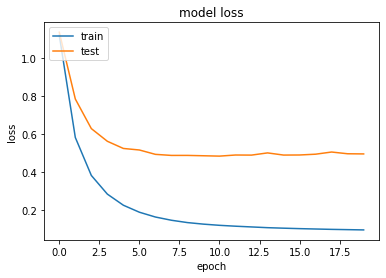

In [6]:
# Visualize training history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('figure.png')
plt.show()
sendFile("figure.png")

In [7]:
import os
model.save_weights('save/')
!zip -r method2_trans.zip save

!split -b 45m method2_trans.zip method2_trans.zip.pt_

for file in os.listdir(os.getcwd()):
        if file.startswith("method2_trans.zip.pt_"):
            sendFile(file)

  adding: save/ (stored 0%)
  adding: save/.data-00000-of-00001 (deflated 12%)
  adding: save/checkpoint (deflated 34%)
  adding: save/.index (deflated 77%)


In [8]:
batch_size = 64
epochs = 5
embed_dim = 128
latent_dim = 128
num_head = 10
decoder_dropout = 0

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(decoder_dropout)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
model_loaded = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")
opt = keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(loss='sparse_categorical_crossentropy', optimizer=opt)    
model_loaded.load_weights('save/')
model_loaded.summary()


def translate2(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = ita_vectorization([decoded_sentence])[:, :-1]
        predictions = model_loaded([tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = ita_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

start_time = time.time()
metric_result = evaluate_model(translate2)
print(metric_result)

ValueError: ignored